In [1]:
import os, sys
import re
import numpy as np
import imageio.v2 as im
import pandas as pd
import cv2
from IPython.display import Image
import matplotlib.pyplot as plt
from cv2 import imwrite
from IPython.core.display import HTML
from scipy.interpolate import splprep
from scipy.interpolate import splev
from tools import skeleton_to_centerline
from cellpose import utils
from scipy.signal import find_peaks
from scipy.signal import argrelmax
from tools import bool_sort
from fil_finder import FilFinder2D, Filament2D
from fil_finder.tests.testing_utils import generate_filament_model
from astropy.io import fits
import astropy.units as u
import tools 
from skimage.util import invert
from imageio.v2 import imwrite
import sknw
from networkx import shortest_path
from skimage.morphology import skeletonize
from sklearn.neighbors import NearestNeighbors
import networkx as nx

cell_path = "Individual_cells/"

Intersection

In [2]:
def intersection(line1,line2,width1=3,width2=3):
    '''
    Find if two lines intersect, or nearly intersect
    
    Parameteres
    -----------
    line1,line2=boolean arrays with 'True' values where the line exists
    width1,width2=amount (in pixels) the line should be dilated to see if a near intersection occurs
    '''
    check = np.sum(line1+line2==2)>0
    if check:
        return True
    else:
        kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT,(width1,width1))
        kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT,(width2,width2))
        dilated1 = cv2.dilate(line1.astype(np.uint8),kernel1,iterations=1)
        dilated2 = cv2.dilate(line2.astype(np.uint8),kernel2,iterations=1)
        check = np.sum(dilated1+dilated2==2)>0
        return check

Skeleton_to_centerline,bool_sort,make_local,pts_to_img

In [367]:
def skeleton_to_centerline(skeleton,axis=False):
    '''
    Finds an ordered list of points which trace out a skeleton with no branches by following the pixels of the centerline 
    elementwise. Starts at the point farthest left and closest to the top. Ends when there are no new points on the skeleton 
    to go to.
    Parameters
    ----------
    skel = a 2d numpy boolean array representing a topological skeleton with no branches
    axis = if true start by finding the min point on the 0 (top-bottom) axis, then 0 (left-right) axis. If false, vice verse. Default False.
    '''
    #initializing lists and starting parameters
    centerline = bool_sort(skeleton,axis) # finds and sorts all points where the skeleton exists. Selects leftest as initial position
    centerline = reorder_opt(centerline)
    return list(centerline)

def reorder_opt(points,NN=5):
    '''
    Find the optimal order of a set of points in an image
    
    Paramters
    ---------
    points = an Nx2 array-like corresponing to a set of points
    
    Returns
    --------
    points = an ordered list of points
    '''
    #find the nearest neighbour of each point
    points = np.array(points)
    clf=NearestNeighbors(n_neighbors=NN).fit(points)
    G = clf.kneighbors_graph()
    T = nx.from_scipy_sparse_array(G)

    mindist = np.inf
    minidx = 0

    order = list(nx.dfs_preorder_nodes(T, 0))
    paths = [list(nx.dfs_preorder_nodes(T, i)) for i in range(len(points))]
    
    for i in range(len(points)):
        p = paths[i]           # order of nodes
        ordered = points[p]    # ordered nodes
        # find cost of that order by the sum of euclidean distances between points (i) and (i+1)
        cost = (((ordered[:-1] - ordered[1:])**2).sum(1)).sum()
        if cost < mindist:
            mindist = cost
            minidx = i
    opt_order = paths[minidx]
    return list(points[opt_order,:])

def make_local(matrix,pos):
    '''
    Extracts the 3x3 array of values around a position in an existing array. If this is not possible (if the position 
    is along an edge), completes the array with rows/columns of 'False' values
    Paramters
    ---------
    matrix = a 2d numpy array
    pos = a numpy array or list, indicating a position in array
    '''
    N = np.shape(matrix)[0]+1
    M = np.shape(matrix)[1]+1
    n1 = max(0,pos[0]-1)
    n2 = min(N,pos[0]+2)
    m1 = max(0,pos[1]-1)
    m2 = min(M,pos[1]+2)
    if n1 == pos[0]-1 and n2 != N and m1==pos[1]-1 and m2!=M:
        return matrix[n1:n2,m1:m2]
    elif n1 == 0:
        if m1 == 0:
            return np.hstack((np.array([[False],[False],[False]]),np.vstack((np.array([False,False]), matrix[n1:n2,m1:m2]))))
        elif m2 == M:
            return np.hstack((np.vstack((np.array([False,False]), matrix[n1:n2,m1:m2])),np.array([[False],[False],[False]])))
        else:
            return np.vstack((np.array([False,False,False]), matrix[n1:n2,m1:m2]))
    elif n2 == N:
        if m1 == 0:
            return np.hstack((np.array([[False],[False],[False]]),np.vstack((matrix[n1:n2,m1:m2],np.array([False,False])))))
        elif m2==M:
            return np.hstack((np.vstack((matrix[n1:n2,m1:m2],np.array([False,False]))),np.array([[False],[False],[False]])))
        else:
            return np.vstack((matrix[n1:n2,m1:m2],np.array([False,False,False])))
    elif m1==0:
        return np.hstack((np.array([[False],[False],[False]]),matrix[n1:n2,m1:m2]))
    elif m2 ==M:
        return np.hstack((matrix[n1:n2,m1:m2],np.array([[False],[False],[False]])))

def bool_sort(array,axis=True):
    '''
    Sort the "True" values in a boolean array, starting from left to right, then top to bottom. If top is true, then start from top to bottom, then
    then left to right.
    Parameters
    ---------
    array = a boolean array to be sorted
    axis = which axis is whose lowest values are put first, default True. If True put the 0 (top-bottom) axis first, if False put the 1 (left-right) axis first.
    '''
    if axis:
        output = np.transpose(np.where(array))
        output = output[output[:,1].argsort()]
        output = output[output[:,0].argsort(kind='mergesort')]
    else:
        output = np.transpose(np.where(array))
        output = output[output[:,0].argsort()]
        output = output[output[:,1].argsort(kind='mergesort')]
    return output

def pts_to_img(pts,base):
    '''converts a list of points to a binary image, with the dimensions of the skeleton'''
    path_in_img=np.zeros(np.shape(base)).astype(bool)
    for pt in pts:
        path_in_img[pt[0],pt[1]]=True
    return path_in_img 

prune2

In [1]:
def prune2(skel,outline,mask,poles,sensitivity=20,crop=0.1):
    def crop_centerline(centerline_path):
        '''Crops a proportion of the points (determined by the crop parameter) from the ends of a centerline with a false pole'''
        crop_length=round(len(centerline_path)*crop)
        image = pts_to_img(centerline_path,skel)
        if true_starts == []:
            if axis:
                start_centerline = image[:,0:N//2]
                start_outline = outline[:,0:N//2]
            else:
                start_centerline=image[0:M//2,:]
                start_outline=outline[0:M//2,:]
            if intersection(start_centerline,start_outline):
                centerline_path= centerline_path[crop_length:]

        if true_ends == []:
            if axis:
                end_centerline = image[:,N//2:N]
                end_outline = outline[:,N//2:N]
            else:
                end_centerline = image[M//2:M,:]
                end_outline = outline[M//2:M,:]
            if intersection(end_centerline,end_outline): 
                centerline_path = centerline_path[:len(centerline_path)-crop_length]
        return centerline_path
    def find_splines(points):
        s = np.linspace(0,1,1000)
        # remove repeated points
        diff = np.diff(points,axis=0)==0
        repeated = np.where(np.array([pt[0] and pt[1] for pt in diff]))
        points = list(np.delete(points,repeated,axis=0))
        if true_starts ==[]:
            points = [np.array([start_pole[1],start_pole[0]])] + points
        if true_ends ==[]:
            points = points + [np.array([end_pole[1],end_pole[0]])]
        tck,U=splprep(np.transpose(points))
        s = np.linspace(0,1,1000)
        [ys,xs]= splev(s,tck)
        return [xs,ys],s
    def in_mask (path,mask):
        '''
        Returns values of a path which are in a mask
        Parameters:
        ---------
        path = numpy array consisting of coordinates in the mask
        mask = numpy boolean array, showing the mask
        '''
        #first remove all values that are not in the picture
        not_in_img =[not(pt[0]<np.shape(mask)[0]-1 and pt[0]>=0 and pt[1]<np.shape(mask)[1]-1 and pt[1]>=0) for pt in path]
        if False in not_in_img:
            not_in_img = np.where(not_in_img)
            path = np.delete(path,not_in_img,0)
        #next remove all values which are not in the mask
        not_in_mask = []
        for i in range (0,len(path)):
            pt = path[i]
            if mask[pt[0],pt[1]]:
                continue
            else:
                not_in_mask.append(i)
        return np.delete(path,not_in_mask,0)
    if np.any(np.isnan(np.array(poles))):
        raise ValueError('Poles must be numerical values, not np.NaN')
    #initializing parameters
    m = np.shape(skel)[0]
    n = np.shape(skel)[1]
    axis = m<n
    poles = list(poles)
    graph = sknw.build_sknw(skel) #creating the graph from the skeleton
    all_paths=shortest_path(graph) #shortest possible paths between the nodes in the skeleton
    nodes = graph.nodes()
    [start_pole,end_pole] = poles
    paths = []
    centerlines=[]
    lengths=[]
    
    #initializing suitable starting and ending positions for the skeleton
    if axis:
        start_nodes = list([i for i in nodes if nodes[i]['o'][1]<n//2])
        end_nodes= list([i for i in nodes if nodes[i]['o'][1]>n//2])
    else:
        start_nodes = list([i for i in nodes if nodes[i]['o'][0]<m//2])
        end_nodes= list([i for i in nodes if nodes[i]['o'][0]>m//2])
    
    # if there are some nodes close to the poles, check only those nodes
    true_starts = [i for i in start_nodes if np.linalg.norm(nodes[i]['o']-np.array([start_pole[1],start_pole[0]]))<sensitivity]
    true_ends = [i for i in end_nodes if np.linalg.norm(nodes[i]['o']-np.array([end_pole[1],end_pole[0]]))<sensitivity]
    if true_starts != []:
        start_nodes = true_starts
    if true_ends !=[]:
        end_nodes = true_ends
    if start_nodes == [] or end_nodes == []:
        raise ValueError('skeleton is on only one side of the cell')
    # take all paths between starting and ending nodes
    for b in  start_nodes:
        for e in end_nodes:
            path = all_paths[b][e]
            paths.append(path)
    if len(paths) == 1:
        path = paths[0]
        edges = [(path[i],path[i+1]) for i in range(len(path)-1)] #edges of the graph corresponding to the centerline
        #initializing centerline
        centerline_path = []
        #calling points from the graph
        for (b,e) in edges:
            edge = graph[b][e]['pts']
            centerline_path = centerline_path + list(edge)
        if len(centerline_path)==0:
            raise ValueError('Skeleton has been erased')
        centerline_path=reorder_opt(np.array(centerline_path))
        if np.linalg.norm(np.array([centerline_path[0][1],centerline_path[0][0]])-end_pole) < np.linalg.norm(np.array([centerline_path[0][1],centerline_path[0][0]])-start_pole):
            centerline_path.reverse()
        centerline_path = crop_centerline(list(centerline_path))
        if len(centerline_path)<=5:
            raise ValueError('Skeleton has been erased')
        centerline_path = reorder_opt(np.array(centerline_path))
        [xs,ys],u = find_splines(centerline_path)
        path = np.round(np.transpose(np.array([ys,xs]))).astype(np.uint32)
        path = in_mask(path,mask)
        length = arc_length([xs,ys])
        pruned_skel = pts_to_img(path,skel)
        return pruned_skel, length, [xs,ys],np.linspace(0,1,100)
    #convert paths (lists of nodes) to centerlines (lists of points)
    for path in paths:
        edges = [(path[i],path[i+1]) for i in range(len(path)-1)] #edges of the graph corresponding to the centerline
        #initializing centerline
        centerline_path = []
        #calling points from the graph
        for (b,e) in edges:
            edge = graph[b][e]['pts']
            centerline_path = centerline_path + list(edge)
        #convert path to binary image
        if len(centerline_path)==0:
            raise ValueError('Skeleton has been erased')
        #crop the centerline, if it has a false pole
        centerline_path=reorder_opt(np.array(centerline_path))
        if np.linalg.norm(np.array([centerline_path[0][1],centerline_path[0][0]])-end_pole) < np.linalg.norm(np.array([centerline_path[0][1],centerline_path[0][0]])-start_pole):
            centerline_path.reverse()
        centerline_path = crop_centerline(list(centerline_path))
        #find the length of each centerline
        length = len(centerline_path)
        # add to the list of centerlines and lengths
        centerlines.append(centerline_path)
        lengths.append(length)
    #choose the longest centerline
    max_index=lengths.index(max(lengths))
    centerline_path=centerlines[max_index]
    if len(centerline_path)<=5:
        raise ValueError('Skeleton has been erased')
    [xs,ys],u = find_splines(centerline_path)
    path = np.round(np.transpose(np.array([ys,xs]))).astype(np.uint32)
    path = in_mask(path,mask)
    pruned_skel = pts_to_img(path,skel)
    length = arc_length([xs,ys])
    return pruned_skel, length, [xs,ys], u

radii, explore_poles, arc_length

In [565]:
def radii(x,y):
    '''
    Finds the radius function of a 2d curve
    
    Parameters
    ---------
    x,y = coordinates of the curve
    
    Returns
    -------
    r = a 1D array containing the distance to the centroid of the curve for each x and y
    centroid = the centroid of the curve
    '''
    length = len(y)
    centroid = np.array([np.sum(x),np.sum(y)])/length
    vectors = np.transpose(np.array([x,y]))-centroid
    return np.array([np.linalg.norm(v) for v in vectors]),centroid

def explore_poles(outline,axis=True):
    '''
    Finds the poles (average distance of the farthest points from the centroid on a smooth closed curve) from x and y coords
    Parameters
    ----------
    outline = boolean array representing the outline of the cell
    axis = which axis the poles are found with respect to. True for the 0 (left-right) axis, False for the 1 (top-bottom) axis
    
    Returns
    --------
    poles 
    '''
    #find points. Want to start on the axis we wish to find them on
    outline_pts = bool_sort(outline,axis)
    outline_pts = reorder_opt(outline_pts,NN=2)
    outline_pts = outline_pts + [outline_pts[0]]
    tck,U=splprep(np.transpose(outline_pts),per=1)
    [y,x] = splev(U,tck)
    r,centroid = radii(x,y)
    cx = centroid[0]
    cy = centroid[1]
    peaks = list(argrelmax(r)[0])
    if len(peaks)<2:
        peaks = peaks+[0,-1]
    if axis:
        right_x_pos=[x[i] for i in peaks if x[i]>cx]
        right_y_pos=[y[i] for i in peaks if x[i]>cx]
        right_rads=[r[i] for i in peaks if x[i]>cx]
        left_x_pos=[x[i] for i in peaks if x[i]<cx]
        left_y_pos=[y[i] for i in peaks if x[i]<cx]
        left_rads=[r[i] for i in peaks if x[i]<cx]
        
        left_pole = np.array([np.dot(left_x_pos,left_rads)/sum(left_rads),np.dot(left_y_pos,left_rads)/sum(left_rads)])
        right_pole = np.array([np.dot(right_x_pos,right_rads)/sum(right_rads),np.dot(right_y_pos,right_rads)/sum(right_rads)])
        return np.array([left_pole,right_pole]), centroid
    else:
        lower_x_pos=[x[i] for i in peaks if y[i]>cy]
        lower_y_pos=[y[i] for i in peaks if y[i]>cy]
        lower_rads=[r[i] for i in peaks if y[i]>cy]
        upper_x_pos=[x[i] for i in peaks if y[i]<cy]
        upper_y_pos=[y[i] for i in peaks if y[i]<cy]
        upper_rads=[r[i] for i in peaks if y[i]<cy]
        
        upper_pole = np.array([np.dot(upper_x_pos,upper_rads)/sum(upper_rads),np.dot(upper_y_pos,upper_rads)/sum(upper_rads)])
        lower_pole= np.array([np.dot(lower_x_pos,lower_rads)/sum(lower_rads),np.dot(lower_y_pos,lower_rads)/sum(lower_rads)])
        return list(np.transpose([upper_pole,lower_pole])), centroid

def arc_length(pts):
    '''
    Find the arclength of a curve given by a set of points
    Paramters
    --------
    pts = array-like coordinates [x1,x2,....]
    '''
    pts = np.array(np.transpose(pts))
    lengths = []
    for i in range (1,len(pts)):
        length = np.linalg.norm(pts[i] - pts[i-1])
        lengths.append(length)
    return np.sum(lengths)

padskel

In [543]:
def padskel(mask):
    '''
    Runs skimage.morphology.skeletonize on a padded version of the mask, to avoid errors.
    
    Parameters
    ----------
    mask = a mask (opencv image)
    
    Returns
    -------
    skel = a skelegon (boolean array)
    '''
    mask = cv2.copyMakeBorder(mask,20,20,20,20,cv2.BORDER_CONSTANT,None,value=0)[:,:,0]>0 #add a border to the skel
    skel = skeletonize(mask)
    skel = skel[20:np.shape(skel)[0]-20,20:np.shape(skel)[1]-20]
    return skel

In [544]:
all_the_cells = os.listdir(cell_path)

# List of masks with associated timepoints and names
maskl = []
for cell in all_the_cells:
    time = re.findall(r'\d+', cell)
    if time != []:
        time = time[0]
        im_path = cell_path + cell + '/masks'
        #create skeletons; save masks, skeletons, and masks with skeletons as lists, save skeletons and skeletons with masks as images
        for mask_name in os.listdir(im_path):
            if mask_name[len(mask_name)-3:len(mask_name)]!='png':
                continue
            ID = int(mask_name[5:6])
            time = int(time)
            mask=im.imread(im_path+'/'+mask_name) #the cells mask (opencv image)
            maskl.append([mask,time,ID])

# 1. Start by finding the input for pruning (mask, outline, skeleton, poles)

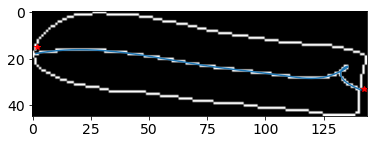

In [611]:
n = 22
mask = np.array(maskl[n][0])
unpruned_skel = padskel(mask)
mask = mask[:,:,0]
outline = utils.masks_to_outlines(mask)
M = np.shape(mask)[0]
N = np.shape(mask)[1]
axis = M<N
poles,centroid = explore_poles(outline,axis)
[start_pole,end_pole]=poles
skel,length,[xs,ys],s = prune2(unpruned_skel,outline,mask,[start_pole,end_pole],sensitivity=5)
plt.imshow(skel+outline, cmap=plt.cm.gray)
plt.plot(xs,ys)
plt.plot(start_pole[0],start_pole[1],'r*')
plt.plot(end_pole[0],end_pole[1],'r*')

# 1.1 (finding poles) Fit a spline to the outline

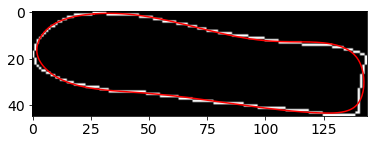

In [612]:
out = np.array(outline)
outline_periodic = bool_sort(outline,axis)
outline_periodic = reorder_opt(outline_periodic,NN=2)
outline_periodic = outline_periodic + [outline_periodic[0]]
tck,u=splprep(np.transpose(outline_periodic),per=1)
[ys,xs]=splev(u,tck)
#[ys,xs] = np.transpose(outline_periodic)
plt.imshow(outline,cmap=plt.cm.gray)
plt.plot(xs,ys,'r-')

# 1.2 (finding poles) Extract the poles of the cell using a centroid-distance transform

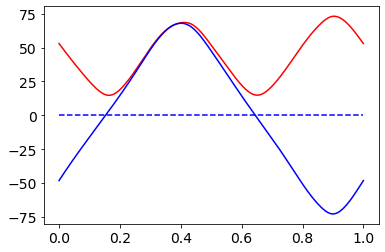

In [613]:
# find the distances to the centroid of the mask at each point on the spline of the outline
r,centroid = tools.radii(xs,ys)
plt.plot(u,r,'r-')
plt.plot(u,xs-centroid[0],'b-')
plt.plot(u,np.zeros(len(u)),'b--')

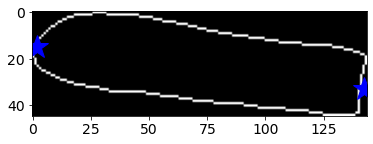

In [614]:
[start_pole,end_pole],centroid=explore_poles(outline,axis)
plt.imshow(outline,cmap=plt.cm.gray)
#plt.plot(xs,ys,'r-')
plt.plot(start_pole[0],start_pole[1],'b*',markersize=24)
plt.plot(end_pole[0],end_pole[1],'b*',markersize=24)

# 2. Compare these poles with the skeleton

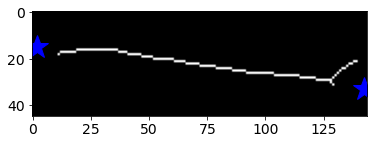

In [615]:
plt.imshow(unpruned_skel,cmap=plt.cm.gray)
plt.plot(start_pole[0],start_pole[1],'b*',markersize=24)
plt.plot(end_pole[0],end_pole[1],'b*',markersize=24)

# 3. Find all nodes and paths through the skeleton using NetworkX

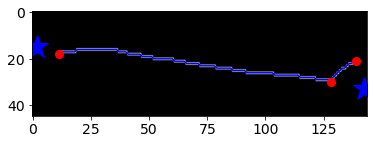

In [616]:
m = np.shape(unpruned_skel)[0]
n = np.shape(unpruned_skel)[1]
graph = sknw.build_sknw(unpruned_skel) #creating the graph from the skeleton
all_paths=shortest_path(graph) #shortest possible paths between the nodes in the skeleton
nodes = graph.nodes()
#divide nodes into starting and ending nodes
start_nodes = list([i for i in nodes if nodes[i]['o'][1]<n//2])
end_nodes= list([i for i in nodes if nodes[i]['o'][1]>n//2])
plt.imshow(unpruned_skel,cmap=plt.cm.gray)
for (s,e) in graph.edges():
    ps = graph[s][e]['pts']
    plt.plot(ps[:,1], ps[:,0], 'b-')
ps = np.array([nodes[i]['o'] for i in nodes])
plt.plot(ps[:,1], ps[:,0], 'r.',markersize=16)
plt.plot(start_pole[0],start_pole[1],'b*',markersize=24)
plt.plot(end_pole[0],end_pole[1],'b*',markersize=24)

# 4. Use only true poles, if they exist

In [617]:
true_starts = [i for i in start_nodes if np.linalg.norm(nodes[i]['o']-np.array([start_pole[1],start_pole[0]]))<5]
true_ends = [i for i in end_nodes if np.linalg.norm(nodes[i]['o']-np.array([end_pole[1],end_pole[0]]))<5]
#start_nodes=true_starts
#end_nodes = true_ends
print (true_starts)
print(true_ends)

[]
[]


# 5. Crop all paths containing a false pole 

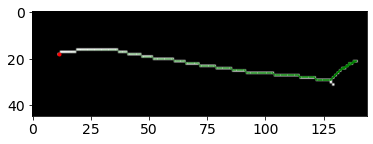

In [618]:
crop = 0.1
paths = []
for b in  start_nodes:
    for e in end_nodes:
        path = all_paths[b][e]
        paths.append(path)
path = paths[0]
edges = [(path[i],path[i+1]) for i in range(len(path)-1)] #edges of the graph corresponding to the centerline
#initializing centerline
centerline_path = []
#calling points from the graph
for (b,e) in edges:
    edge = graph[b][e]['pts']
    centerline_path = centerline_path + list(edge)
centerline_path = reorder_opt(np.array(centerline_path))
if np.linalg.norm(np.array([centerline_path[0][1],centerline_path[0][0]])-end_pole) < np.linalg.norm(np.array([centerline_path[0][1],centerline_path[0][0]])-start_pole):
    centerline_path.reverse()
crop_length=round(len(centerline_path)*crop)
image = pts_to_img(centerline_path,unpruned_skel)

[y,x] = np.transpose(centerline_path)
plt.imshow(unpruned_skel,cmap=plt.cm.gray)
for i in range(len(centerline_path)-1):
    plt.plot(x[i:i+2],y[i:i+2],
             alpha=float(i)/(len(centerline_path)-1),color = 'green')
plt.plot(centerline_path[0][1],centerline_path[0][0],'r.')

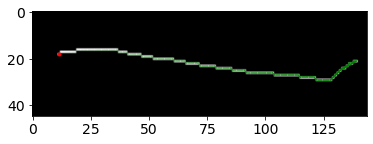

In [619]:
if true_starts == []:
    if axis:
        start_centerline = image[:,0:N//2]
        start_outline = outline[:,0:N//2]
    else:
        start_centerline=image[0:M//2,:]
        start_outline=outline[0:M//2,:]
    if intersection(start_centerline,start_outline):
        centerline_path= centerline_path[crop_length:]

if true_ends == []:
    if axis:
        end_centerline = image[:,N//2:N]
        end_outline = outline[:,N//2:N]
    else:
        end_centerline = image[M//2:M,:]
        end_outline = outline[M//2:M,:]
    if intersection(end_centerline,end_outline): 
        centerline_path = centerline_path[:len(centerline_path)-crop_length]

centerline = pts_to_img(centerline_path,unpruned_skel)
plt.imshow(centerline,cmap=plt.cm.gray)
for i in range(len(centerline_path)-1):
    plt.plot(x[i:i+2],y[i:i+2],
             alpha=float(i)/(len(centerline_path)-1),color = 'green')
plt.plot(centerline_path[0][1],centerline_path[0][0],'r.')

In [620]:
def crop_centerline(centerline_path):
    '''Crops a proportion of the points (determined by the crop parameter) from the ends of a centerline with a false pole'''
    crop_length=round(len(centerline_path)*crop)
    image = pts_to_img(centerline_path,unpruned_skel)
    if true_starts == []:
        if axis:
            start_centerline = image[:,0:N//2]
            start_outline = outline[:,0:N//2]
        else:
            start_centerline=image[0:M//2,:]
            start_outline=outline[0:M//2,:]
        if intersection(start_centerline,start_outline):
            centerline_path= centerline_path[crop_length:]

    if true_ends == []:
        if axis:
            end_centerline = image[:,N//2:N]
            end_outline = outline[:,N//2:N]
        else:
            end_centerline = image[M//2:M,:]
            end_outline = outline[M//2:M,:]
        if intersection(end_centerline,end_outline): 
            centerline_path = centerline_path[:len(centerline_path)-crop_length]
    return centerline_path

In [621]:
#select all paths from stats to ends
paths = []
lengths=[]
for b in  start_nodes:
    for e in end_nodes:
        path = all_paths[b][e]
        paths.append(path)
#convert paths (lists of nodes) to centerlines (lists of points)
centerlines=[]
for path in paths:
    edges = [(path[i],path[i+1]) for i in range(len(path)-1)] #edges of the graph corresponding to the centerline
    #initializing centerline
    centerline_path = []
    #calling points from the graph
    for (b,e) in edges:
        edge = graph[b][e]['pts']
        centerline_path = centerline_path + list(edge)
    #convert path to binary image
    if len(centerline_path)==0:
        raise ValueError('Skeleton has been erased')
    #crop the centerline, if it has a false pole
    centerline_path=reorder_opt(np.array(centerline_path))
    if np.linalg.norm(np.array([centerline_path[0][1],centerline_path[0][0]])-end_pole) < np.linalg.norm(np.array([centerline_path[0][1],centerline_path[0][0]])-start_pole):
        centerline_path.reverse()
    centerline_path = crop_centerline(list(centerline_path))
    #find the length of each centerline
    length = len(centerline_path)
    # add to the list of centerlines and lengths
    centerlines.append(centerline_path)
    lengths.append(length)


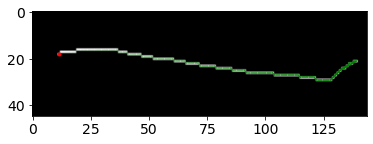

In [622]:
centerline_path=centerlines[0]
centerline = pts_to_img(centerline_path,unpruned_skel)
plt.imshow(centerline,cmap=plt.cm.gray)
for i in range(len(centerline_path)-1):
    plt.plot(x[i:i+2],y[i:i+2],
             alpha=float(i)/(len(centerline_path)-1),color = 'green')
plt.plot(centerline_path[0][1],centerline_path[0][0],'r.')

# 6. Choose the longest through the skeleton

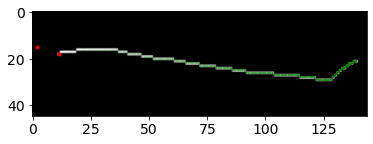

In [623]:
#choose the longest centerline
max_index=lengths.index(max(lengths))
centerline_path=centerlines[max_index]
centerline = pts_to_img(centerline_path,unpruned_skel)
plt.imshow(centerline,cmap=plt.cm.gray)
for i in range(len(centerline_path)-1):
    plt.plot(x[i:i+2],y[i:i+2],
             alpha=float(i)/(len(centerline_path)-1),color = 'green')
plt.plot(centerline_path[0][1],centerline_path[0][0],'r.')
plt.plot(start_pole[0],start_pole[1],'r.')

# 7. Find the spline of the centerline and extend it to the poles

In [624]:
if true_starts ==[]:
    centerline_path = [np.array([start_pole[1],start_pole[0]])] + centerline_path
if true_ends ==[]:
    centerline_path = centerline_path + [np.array([end_pole[1],end_pole[0]])]


In [625]:
tck,U=splprep(np.transpose(centerline_path))
s = np.linspace(0,1,1000)
[y,x]= splev(s,tck)

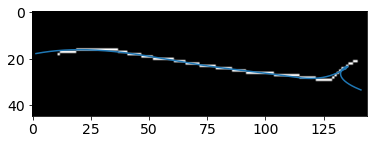

In [626]:
plt.imshow(centerline,cmap=plt.cm.gray)
plt.plot(x,y)

In [632]:
path = np.round(np.transpose(np.array([y,x]))).astype(np.uint32)


# 7.1 Remove points that are not in the image

In [633]:
#first remove all values that are not in the picture
not_in_img =[not(pt[0]<np.shape(mask)[0]-1 and pt[0]>=0 and pt[1]<np.shape(mask)[1]-1 and pt[1]>=0) for pt in path]
if False in not_in_img:
    not_in_img = np.where(not_in_img)
    path = np.delete(path,not_in_img,0)
#next remove all values which are not in the mask
not_in_mask = []
for i in range (0,len(path)):
    pt = path[i]
    if mask[pt[0],pt[1]]:
        continue
    else:
        not_in_mask.append(i)
path= np.delete(path,not_in_mask,0)


In [634]:
pruned_skel = pts_to_img(path,unpruned_skel)

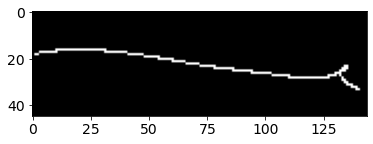

In [635]:
plt.imshow(pruned_skel,cmap=plt.cm.gray)